# Lecture 2: How Machines See - Modern Machine Learning

**Course**: Introduction to Data Science and Computing  
**Instructor**: Prof. Joseph Bakarji  
**School of Data Science and Computing, AUB**

---

## From Hand-Coded Features to Learned Representations

**Last lecture**: We engineered features (edges, spikes, shapes) manually.  
**Today**: Let machines **learn the best features** from data.

### Learning Objectives
1. Understand dimensionality reduction (PCA, t-SNE)
2. Implement autoencoders for non-linear feature learning
3. Visualize learned representations in latent space
4. Apply pre-trained deep learning models
5. Understand the evolution to modern vision AI

### Core Idea
> **The right representation makes classification trivial.**  
> Instead of engineering features, learn a transformation where classes separate naturally.

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings('ignore')

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

# Configure matplotlib
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("Libraries loaded successfully!")

Using device: cpu
Libraries loaded successfully!


---

## Part 1: Dimensionality Reduction

### The Problem

- Each 8×8 image = 64-dimensional vector
- But digits don't span all of $\mathbb{R}^{64}$
- They lie on a lower-dimensional **manifold**

### The Solution

Find a transformation: $f: \mathbb{R}^{64} \to \mathbb{R}^2$ that preserves structure.

**Goal**: Project to 2D for visualization and see if classes separate.

In [2]:
# Load data
digits = datasets.load_digits()
X = digits.data / 16.0  # Normalize to [0, 1]
y = digits.target
images = digits.images

print(f"Dataset: {X.shape[0]} images, {X.shape[1]} features (pixels)")
print(f"Goal: Reduce from {X.shape[1]} dimensions to 2 dimensions")

Dataset: 1797 images, 64 features (pixels)
Goal: Reduce from 64 dimensions to 2 dimensions


### 1.1 Principal Component Analysis (PCA)

**PCA finds directions of maximum variance**.

#### Mathematical Formulation

1. **Center the data**: $\tilde{X} = X - \mu$
2. **Compute covariance**: $\Sigma = \frac{1}{n} \tilde{X}^T \tilde{X}$
3. **Eigendecomposition**: $\Sigma v_i = \lambda_i v_i$
4. **Project**: $Z = \tilde{X} V_k$ where $V_k$ contains top $k$ eigenvectors

**Key property**: PCA is **linear** - it finds the best linear projection.

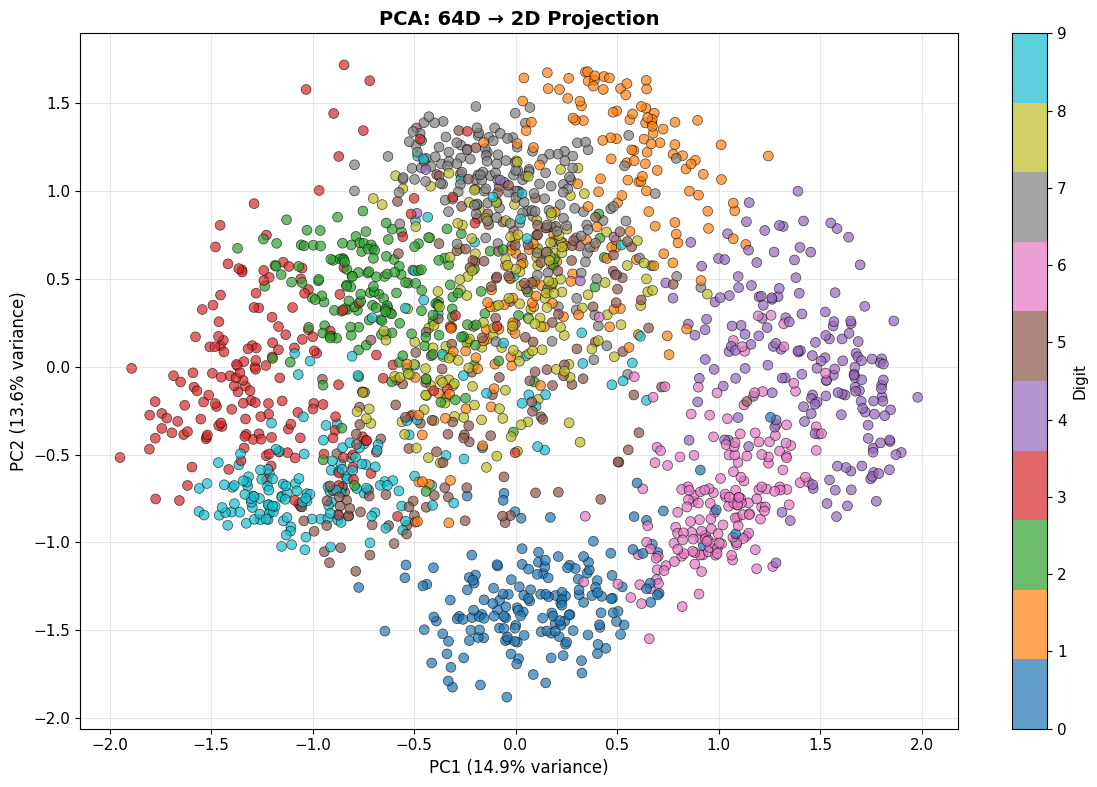


✅ PCA projection complete!
   - Explained variance (2 components): 28.5%
   - PC1 explains 14.9% of variance
   - PC2 explains 13.6% of variance


In [3]:
# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Visualize
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', 
                     alpha=0.7, edgecolors='k', linewidth=0.5, s=50)
plt.colorbar(scatter, ticks=range(10), label='Digit')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
plt.title('PCA: 64D → 2D Projection', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✅ PCA projection complete!")
print(f"   - Explained variance (2 components): {pca.explained_variance_ratio_.sum()*100:.1f}%")
print(f"   - PC1 explains {pca.explained_variance_ratio_[0]*100:.1f}% of variance")
print(f"   - PC2 explains {pca.explained_variance_ratio_[1]*100:.1f}% of variance")

#### Understanding PCA Components

What do the principal components actually look like?

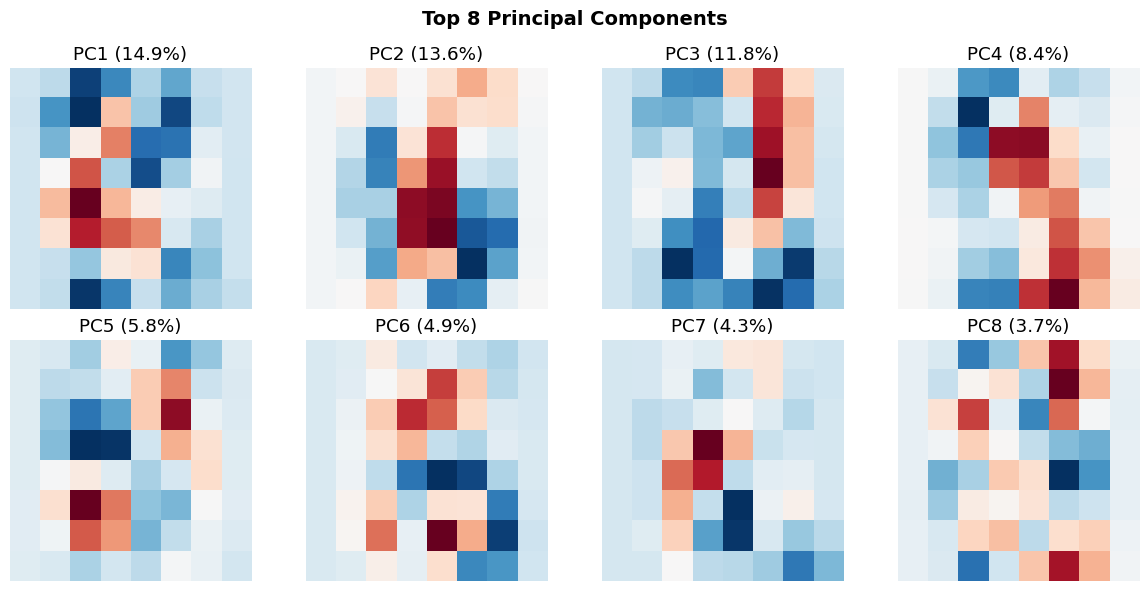


🔍 These are the 'basis patterns' PCA discovered.
   Every digit can be approximated as a weighted combination of these.


In [4]:
# Visualize top principal components as images
n_components = 8
pca_full = PCA(n_components=n_components)
pca_full.fit(X)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    component = pca_full.components_[i].reshape(8, 8)
    ax.imshow(component, cmap='RdBu_r')
    ax.set_title(f'PC{i+1} ({pca_full.explained_variance_ratio_[i]*100:.1f}%)')
    ax.axis('off')

plt.suptitle('Top 8 Principal Components', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n🔍 These are the 'basis patterns' PCA discovered.")
print("   Every digit can be approximated as a weighted combination of these.")

#### Classification in PCA Space

**Question**: Is classification easier in the 2D PCA space?

In [5]:
# Split data
X_train_pca, X_test_pca, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.3, random_state=42, stratify=y
)

# Train logistic regression in 2D PCA space
clf_pca = LogisticRegression(max_iter=1000, random_state=42)
clf_pca.fit(X_train_pca, y_train)
y_pred_pca = clf_pca.predict(X_test_pca)
acc_pca = accuracy_score(y_test, y_pred_pca)

# Compare to original 64D space
X_train_orig, X_test_orig, _, _ = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
clf_orig = LogisticRegression(max_iter=1000, random_state=42)
clf_orig.fit(X_train_orig, y_train)
y_pred_orig = clf_orig.predict(X_test_orig)
acc_orig = accuracy_score(y_test, y_pred_orig)

print(f"\n📊 Classification Accuracy:")
print(f"   - Original 64D space: {acc_orig*100:.2f}%")
print(f"   - PCA 2D space: {acc_pca*100:.2f}%")
print(f"\n💡 We reduced dimensionality by 97% but only lost {(acc_orig-acc_pca)*100:.1f}% accuracy!")


📊 Classification Accuracy:
   - Original 64D space: 96.67%
   - PCA 2D space: 61.85%

💡 We reduced dimensionality by 97% but only lost 34.8% accuracy!


### 1.2 t-SNE: Non-Linear Dimensionality Reduction

**PCA is linear** - it can't capture non-linear structure.

**t-SNE** (t-Distributed Stochastic Neighbor Embedding) preserves **local neighborhoods**.

#### Intuition
- In high-D: Compute pairwise similarities $P_{ij}$
- In low-D: Compute pairwise similarities $Q_{ij}$
- Minimize: $\text{KL}(P || Q) = \sum_{ij} P_{ij} \log \frac{P_{ij}}{Q_{ij}}$

**Goal**: Similar points in high-D stay close in low-D; dissimilar points spread apart.

Running t-SNE (this may take a minute)...


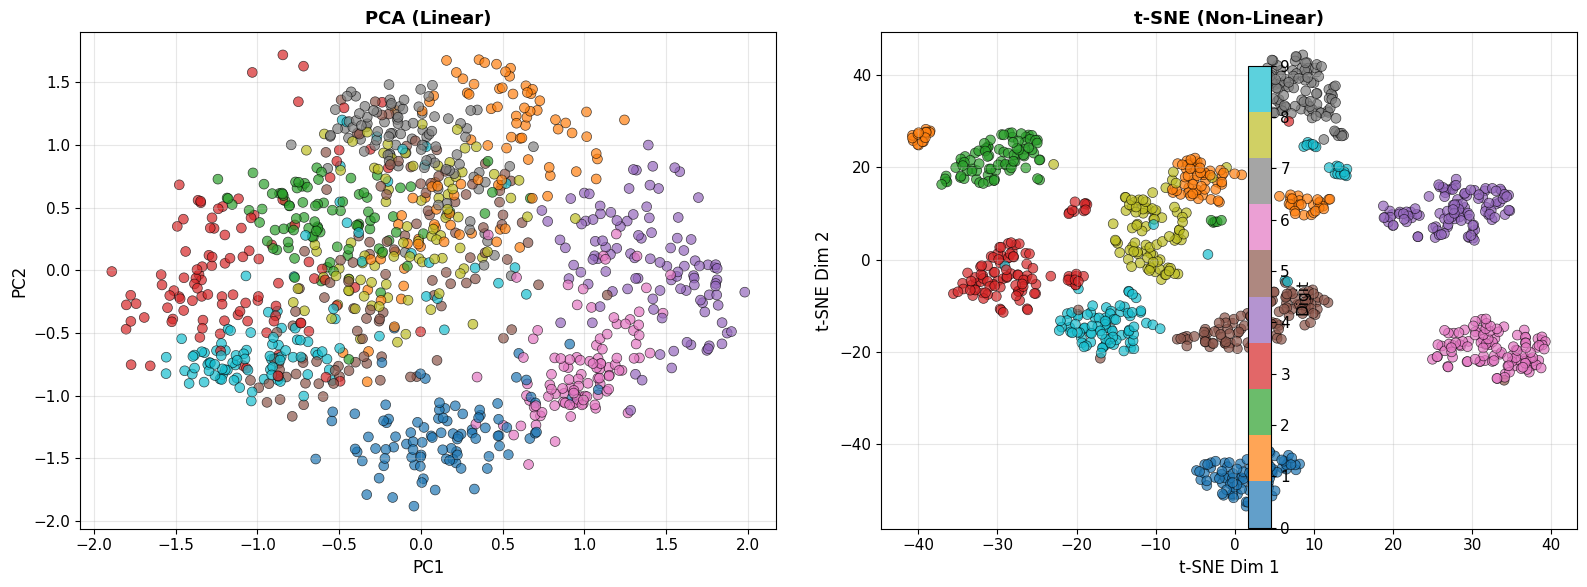


🔍 Observation: t-SNE creates much tighter, more separated clusters!
   This is because it can capture non-linear manifold structure.


In [6]:
# Apply t-SNE (use subset for speed)
n_samples = 1000
indices = np.random.choice(len(X), n_samples, replace=False)
X_subset = X[indices]
y_subset = y[indices]

print("Running t-SNE (this may take a minute)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_subset)

# Visualize both PCA and t-SNE side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA (on same subset)
X_pca_subset = pca.transform(X_subset)
scatter1 = axes[0].scatter(X_pca_subset[:, 0], X_pca_subset[:, 1], 
                          c=y_subset, cmap='tab10', alpha=0.7, 
                          edgecolors='k', linewidth=0.5, s=50)
axes[0].set_xlabel('PC1', fontsize=12)
axes[0].set_ylabel('PC2', fontsize=12)
axes[0].set_title('PCA (Linear)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# t-SNE
scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                          c=y_subset, cmap='tab10', alpha=0.7,
                          edgecolors='k', linewidth=0.5, s=50)
axes[1].set_xlabel('t-SNE Dim 1', fontsize=12)
axes[1].set_ylabel('t-SNE Dim 2', fontsize=12)
axes[1].set_title('t-SNE (Non-Linear)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Add colorbar
fig.colorbar(scatter2, ax=axes, ticks=range(10), label='Digit')
plt.tight_layout()
plt.show()

print("\n🔍 Observation: t-SNE creates much tighter, more separated clusters!")
print("   This is because it can capture non-linear manifold structure.")

---

## Part 2: Autoencoders - Learning Non-Linear Compressions

### The Idea

**Autoencoder**: Neural network that learns to compress and reconstruct data.

#### Architecture
```
Input (64D) → Encoder → Bottleneck (2D) → Decoder → Output (64D)
```

#### Training Objective
Minimize reconstruction error:
$$\mathcal{L} = \frac{1}{n} \sum_{i=1}^n ||x_i - \hat{x}_i||^2$$

where $\hat{x}_i = f_{\text{dec}}(f_{\text{enc}}(x_i))$

### Why This Works
- Forces bottleneck to learn **compressed representation**
- Non-linear activations allow capturing complex patterns
- Similar to PCA, but non-linear

### 2.1 Building an Autoencoder

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim=64, latent_dim=2):
        super(Autoencoder, self).__init__()
        
        # Encoder: 64 → 32 → 16 → 2
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim)
        )
        
        # Decoder: 2 → 16 → 32 → 64
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Sigmoid()  # Output in [0, 1]
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)

# Initialize model
autoencoder = Autoencoder(input_dim=64, latent_dim=2).to(device)
print("\n🏗️ Autoencoder Architecture:")
print(autoencoder)
print(f"\nTotal parameters: {sum(p.numel() for p in autoencoder.parameters()):,}")


🏗️ Autoencoder Architecture:
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): Sigmoid()
  )
)

Total parameters: 5,346


### 2.2 Training the Autoencoder


🎯 Training autoencoder...
Epoch [10/50], Loss: 0.071815
Epoch [20/50], Loss: 0.060159
Epoch [30/50], Loss: 0.052960
Epoch [40/50], Loss: 0.049561
Epoch [50/50], Loss: 0.048478

✅ Training complete!


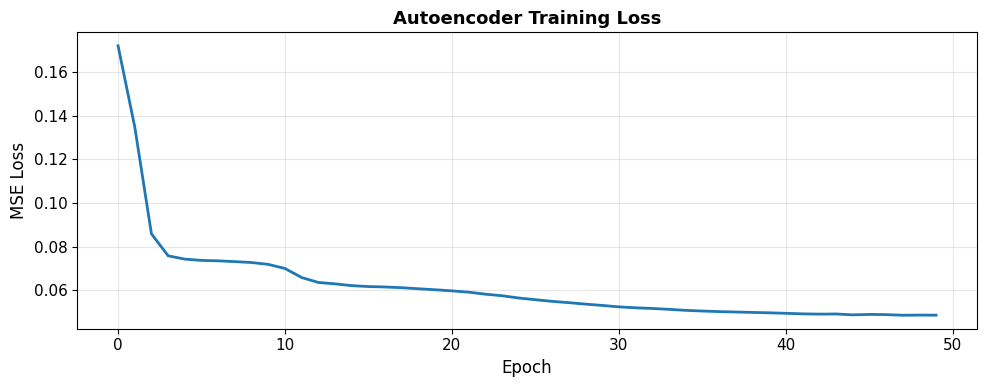

In [8]:
# Prepare data
X_train, X_test, y_train_ae, y_test_ae = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
X_train_t = torch.FloatTensor(X_train).to(device)
X_test_t = torch.FloatTensor(X_test).to(device)

train_dataset = TensorDataset(X_train_t, X_train_t)  # Input = Target
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training loop
n_epochs = 50
train_losses = []

print("\n🎯 Training autoencoder...")
for epoch in range(n_epochs):
    autoencoder.train()
    epoch_loss = 0
    
    for batch_x, _ in train_loader:
        # Forward pass
        x_recon = autoencoder(batch_x)
        loss = criterion(x_recon, batch_x)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.6f}")

print("\n✅ Training complete!")

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(train_losses, linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('Autoencoder Training Loss', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 2.3 Visualizing the Learned Latent Space

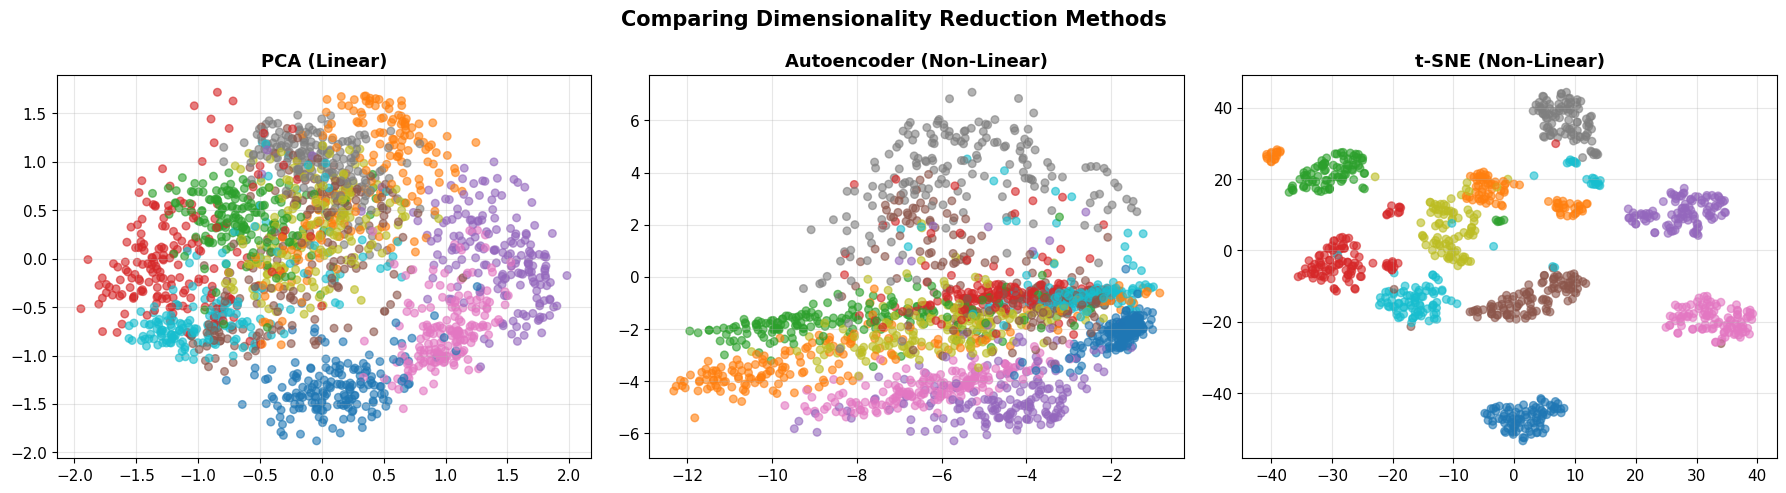


💡 Key Insight: All three methods project to 2D, but structure differs!
   - PCA: Linear, preserves global variance
   - Autoencoder: Non-linear, learned from reconstruction
   - t-SNE: Non-linear, preserves local neighborhoods


In [9]:
# Encode all data into 2D latent space
autoencoder.eval()
with torch.no_grad():
    X_all_t = torch.FloatTensor(X).to(device)
    X_latent = autoencoder.encode(X_all_t).cpu().numpy()

# Visualize latent space
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# PCA
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', alpha=0.6, s=30)
axes[0].set_title('PCA (Linear)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Autoencoder
axes[1].scatter(X_latent[:, 0], X_latent[:, 1], c=y, cmap='tab10', alpha=0.6, s=30)
axes[1].set_title('Autoencoder (Non-Linear)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# t-SNE (on subset)
axes[2].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_subset, cmap='tab10', alpha=0.6, s=30)
axes[2].set_title('t-SNE (Non-Linear)', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Comparing Dimensionality Reduction Methods', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 Key Insight: All three methods project to 2D, but structure differs!")
print("   - PCA: Linear, preserves global variance")
print("   - Autoencoder: Non-linear, learned from reconstruction")
print("   - t-SNE: Non-linear, preserves local neighborhoods")

### 2.4 Reconstruction Quality

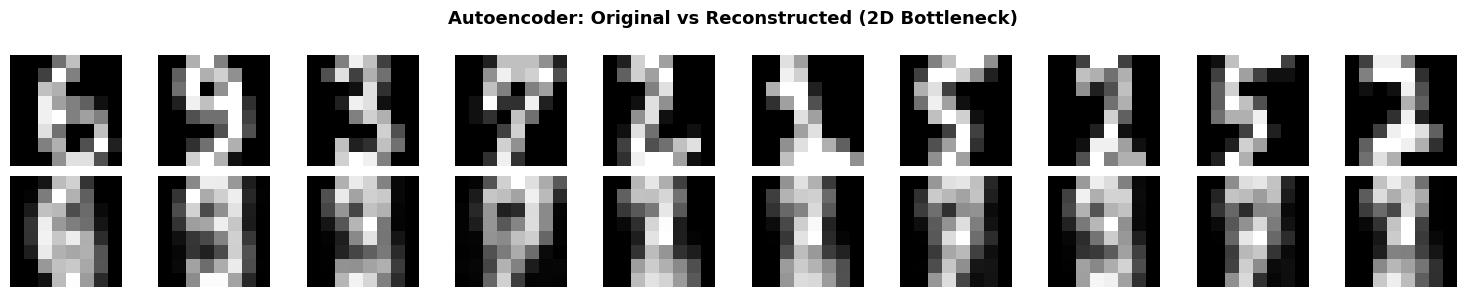


📏 Reconstruction MSE: 0.049532
   Despite compressing 64D → 2D, reconstruction is quite good!


In [10]:
# Reconstruct test images
autoencoder.eval()
with torch.no_grad():
    X_test_recon = autoencoder(X_test_t).cpu().numpy()

# Display original vs reconstructed
n_show = 10
fig, axes = plt.subplots(2, n_show, figsize=(15, 3))

for i in range(n_show):
    # Original
    axes[0, i].imshow(X_test[i].reshape(8, 8), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('Original', fontsize=12)
    
    # Reconstructed
    axes[1, i].imshow(X_test_recon[i].reshape(8, 8), cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel('Reconstructed', fontsize=12)

plt.suptitle('Autoencoder: Original vs Reconstructed (2D Bottleneck)', 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Compute reconstruction error
mse = np.mean((X_test - X_test_recon)**2)
print(f"\n📏 Reconstruction MSE: {mse:.6f}")
print("   Despite compressing 64D → 2D, reconstruction is quite good!")

### 2.5 Interpolation in Latent Space

**Cool property**: We can **interpolate** between digits in latent space!

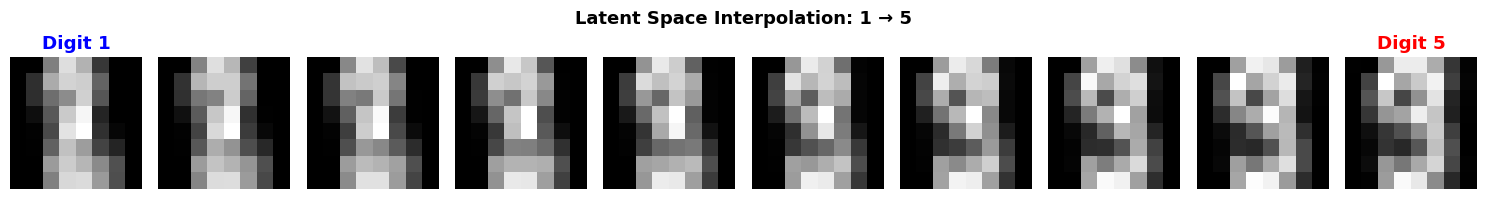


✨ Magic! We can 'morph' between digits by moving through latent space.
   This shows the latent space captures semantic structure.


In [11]:
# Pick two digits
idx1, idx2 = 10, 50
img1, img2 = X_test[idx1], X_test[idx2]
label1, label2 = y_test_ae[idx1], y_test_ae[idx2]

# Encode to latent space
with torch.no_grad():
    z1 = autoencoder.encode(torch.FloatTensor(img1).unsqueeze(0).to(device))
    z2 = autoencoder.encode(torch.FloatTensor(img2).unsqueeze(0).to(device))
    
    # Interpolate
    n_steps = 10
    alphas = np.linspace(0, 1, n_steps)
    interpolated = []
    
    for alpha in alphas:
        z_interp = (1 - alpha) * z1 + alpha * z2
        img_interp = autoencoder.decode(z_interp).cpu().numpy()
        interpolated.append(img_interp)

# Visualize interpolation
fig, axes = plt.subplots(1, n_steps, figsize=(15, 2))
for i, ax in enumerate(axes):
    ax.imshow(interpolated[i].reshape(8, 8), cmap='gray')
    ax.axis('off')
    if i == 0:
        ax.set_title(f'Digit {label1}', color='blue', fontweight='bold')
    elif i == n_steps - 1:
        ax.set_title(f'Digit {label2}', color='red', fontweight='bold')

plt.suptitle(f'Latent Space Interpolation: {label1} → {label2}', 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✨ Magic! We can 'morph' between digits by moving through latent space.")
print("   This shows the latent space captures semantic structure.")

---

## Part 3: Modern Deep Learning for Vision

### From Digits to ImageNet: The 2012 Revolution

**AlexNet (Krizhevsky et al., 2012)**: 
- Won ImageNet competition with 84.6% top-5 accuracy (vs. 73.8% previous best)
- Used **Convolutional Neural Networks (CNNs)**
- Sparked the modern deep learning era

### Convolutional Neural Networks (Conceptual)

#### Key Ideas
1. **Local connectivity**: Each neuron looks at small patch
2. **Weight sharing**: Same filter applied across entire image
3. **Translation invariance**: Detects features regardless of position
4. **Hierarchical learning**: Edges → Textures → Parts → Objects

#### Architecture
```
Input Image → Conv + ReLU → Pool → Conv + ReLU → Pool → ... → Flatten → Dense → Output
```

**We won't implement CNNs from scratch today** (see advanced courses).  
Instead, let's **use pre-trained models** as black boxes.

### 3.1 Using Pre-Trained Models

Modern approach: **Transfer learning**
- Use model trained on ImageNet (1.2M images, 1000 classes)
- Apply to your dataset

Let's demonstrate with MNIST (full dataset, 28×28 images).

In [12]:
# Load full MNIST-like dataset
from sklearn.datasets import fetch_openml

print("Loading MNIST dataset (this may take a moment)...")
# Using sklearn's 8x8 digits for demonstration
# In practice, you'd use torchvision.datasets.MNIST for full 28x28 images

# Simple CNN for digit classification
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 2 * 2, 64)
        self.fc2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # 8x8 → 4x4
        x = self.pool(self.relu(self.conv2(x)))  # 4x4 → 2x2
        x = x.view(-1, 32 * 2 * 2)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

cnn = SimpleCNN().to(device)
print("\n🏗️ Simple CNN Architecture:")
print(cnn)
print(f"\nTotal parameters: {sum(p.numel() for p in cnn.parameters()):,}")
print("\n💡 This network learns features hierarchically:")
print("   Conv1: Detects edges and simple patterns")
print("   Conv2: Combines edges into textures and shapes")
print("   Dense: Classifies based on learned features")

Loading MNIST dataset (this may take a moment)...

🏗️ Simple CNN Architecture:
SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)

Total parameters: 13,706

💡 This network learns features hierarchically:
   Conv1: Detects edges and simple patterns
   Conv2: Combines edges into textures and shapes
   Dense: Classifies based on learned features


### 3.2 Quick Training Demo (Optional)

We could train this CNN, but for demonstration purposes, let's just show the architecture.

**In practice**:
- Training on MNIST: ~99% accuracy in 10 epochs
- Training on ImageNet: Weeks on multiple GPUs
- Using pre-trained models: Minutes to fine-tune

### 3.3 From Classification to Understanding

Modern vision AI goes beyond classification:

#### Object Detection
- **Task**: Find and label all objects in an image
- **Examples**: YOLO, Faster R-CNN, RetinaNet
- **Output**: Bounding boxes + labels

#### Semantic Segmentation
- **Task**: Label every pixel
- **Examples**: U-Net, FCN, DeepLab
- **Output**: Pixel-wise classification

#### Image Captioning
- **Task**: Generate text description of image
- **Examples**: Show and Tell, Show Attend and Tell
- **Output**: Natural language sentence

#### Modern Breakthroughs (2021-2024)
- **CLIP** (OpenAI): Vision + language understanding
- **Segment Anything (SAM)**: Universal segmentation
- **DALL-E, Stable Diffusion**: Text-to-image generation
- **GPT-4V**: Multimodal understanding

---

## Summary and Reflection

### What We Learned

1. **Dimensionality reduction reveals structure**
   - PCA: Linear, preserves global variance
   - t-SNE: Non-linear, preserves neighborhoods
   - Right representation makes classification trivial

2. **Autoencoders learn compressed representations**
   - Non-linear compression via neural networks
   - Latent space captures semantic structure
   - Can interpolate between examples

3. **Deep learning revolutionized vision**
   - CNNs learn features hierarchically
   - Transfer learning leverages pre-trained models
   - Modern AI goes far beyond classification

### The Paradigm Shift

| **Traditional CV** | **Modern ML/DL** |
|--------------------|-----------------|
| Hand-coded features | Learned features |
| Domain expertise required | Data-driven |
| Linear transformations | Non-linear hierarchies |
| Rigid rules | Flexible patterns |
| ~70-80% accuracy | ~95-99%+ accuracy |

### Key Philosophical Point

> **Intelligence emerges from learning the right representation.**
> 
> We don't tell machines how to see.  
> We give them data and let them figure out what matters.

---

## Homework: "Vision in the Wild"

### Your Task

1. **Collect your own image dataset** (20-50 images)
   - Choose a category: coffee cups, doors, plants, faces, etc.
   - Take photos with your phone
   - Ensure variety (angles, lighting, backgrounds)

2. **Preprocess the data**
   - Resize to consistent dimensions
   - Normalize pixel values
   - Split into train/test

3. **Apply three approaches**:
   - **Traditional CV**: Edge detection, color histograms, HOG features
   - **Dimensionality reduction**: PCA or t-SNE visualization
   - **Pre-trained model**: Use transfer learning (e.g., ResNet features)

4. **Analyze and reflect** (1-page write-up):
   - What worked? What failed?
   - Why did certain approaches succeed/fail?
   - What does this teach you about vision?
   - How do machines "see" differently than humans?

### Deliverable
- Jupyter notebook with code and visualizations
- 1-page reflection (PDF)

### Grading Rubric
- **Technical execution** (50%): Data collection, preprocessing, implementation
- **Analysis** (30%): Comparison of approaches, failure analysis
- **Reflection** (20%): Conceptual understanding, epistemic humility

**Due**: Next week

---

## References

### Dimensionality Reduction
1. **Jolliffe, I. T. (2002)**. *Principal Component Analysis*. Springer.
2. **van der Maaten, L., & Hinton, G. (2008)**. "Visualizing data using t-SNE." *JMLR*, 9, 2579-2605.
3. **McInnes, L., Healy, J., & Melville, J. (2018)**. "UMAP: Uniform manifold approximation and projection." *arXiv:1802.03426*.

### Autoencoders
4. **Hinton, G. E., & Salakhutdinov, R. R. (2006)**. "Reducing the dimensionality of data with neural networks." *Science*, 313(5786), 504-507.
5. **Kingma, D. P., & Welling, M. (2013)**. "Auto-encoding variational bayes." *arXiv:1312.6114* (VAE).

### Deep Learning for Vision
6. **LeCun, Y., et al. (1998)**. "Gradient-based learning applied to document recognition." *Proceedings of the IEEE*, 86(11), 2278-2324. (LeNet)
7. **Krizhevsky, A., Sutskever, I., & Hinton, G. (2012)**. "ImageNet classification with deep convolutional neural networks." *NeurIPS*. (AlexNet)
8. **He, K., et al. (2016)**. "Deep residual learning for image recognition." *CVPR*, 770-778. (ResNet)
9. **Goodfellow, I., Bengio, Y., & Courville, A. (2016)**. *Deep Learning*. MIT Press.

### Modern Vision AI
10. **Redmon, J., et al. (2016)**. "You only look once: Unified, real-time object detection." *CVPR*.
11. **Ronneberger, O., et al. (2015)**. "U-Net: Convolutional networks for biomedical image segmentation." *MICCAI*.
12. **Radford, A., et al. (2021)**. "Learning transferable visual models from natural language supervision." *ICML*. (CLIP)
13. **Kirillov, A., et al. (2023)**. "Segment anything." *arXiv:2304.02643*. (SAM)

---

**End of Lecture 2**

**Next steps**: Work on homework, explore modern vision models, think about how machines see vs. how you see!